In [47]:
from datetime import datetime,timedelta
import os
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb

from scipy.stats import pearsonr
import xml.etree.ElementTree as et
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report,precision_score,accuracy_score,recall_score
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

addressPrefix='C:/Users/sorush.omidvar/Google Drive/Documents/Educational/TAMU/Research/CGM Dataset/OhioT1/'
if not os.path.exists(addressPrefix):
    addressPrefix='C:/GDrive/Documents/Educational/TAMU/Research/CGM Dataset/OhioT1/'
pd.options.mode.chained_assignment = None  # default='warn'
plt.style.use({'figure.facecolor':'white'})

In [82]:
def DataReader(fileAddress):
    xmlTree = et.parse(fileAddress)
    xmlRoot = xmlTree.getroot()
    patientId=xmlRoot.attrib
    patientId=patientId['id']
    data=[]
    for parameter in xmlRoot:
        parameterName=parameter.tag
        for element in parameter:
            temporary=element.attrib
            if 'description' in temporary: #Skipping the illness
                continue
            if 'ts_begin' in temporary:
                tStartTemp=temporary['ts_begin']
            elif 'ts' in temporary:
                tStartTemp=temporary['ts']
            elif 'tbegin' in temporary:
                tStartTemp=temporary['tbegin']
            tStart = datetime.strptime(tStartTemp, '%d-%m-%Y %H:%M:%S')

            if 'ts_end' in temporary:
                tEndTemp=temporary['ts_end']
                tEnd = datetime.strptime(tEndTemp, '%d-%m-%Y %H:%M:%S')
            elif 'tend' in temporary:
                tEndTemp=temporary['tend']
                tEnd = datetime.strptime(tEndTemp, '%d-%m-%Y %H:%M:%S')
            elif 'duration' in temporary:
                tEnd=tStart+timedelta(minutes=int(temporary["duration"]))
            else:
                tEnd=tStart

            if 'value' in temporary:
                val=float(temporary['value'])
            elif 'dose' in temporary:
                val=float(temporary['dose'])
            elif 'carbs' in temporary:
                val=float(temporary['carbs'])
            elif 'quality' in temporary:
                val=float(temporary['quality'])
            elif 'intensity' in temporary:
                val=float(temporary['intensity'])

            extra=''
            if 'bwz_carb_input' in temporary:
                extra=float(temporary['bwz_carb_input'])
            elif 'type' in temporary:
                extra=temporary['type']

            data.append([patientId,parameterName,tStart,tEnd,val,extra])
    df = pd.DataFrame(data, columns = ["Patient","Parameter", "Start","End","Value","Extra"])
    df.sort_values(by=['Parameter', 'Start'],inplace=True)
    return df

def dataResEnhancer(df):
    gapLength=1
    gapList=[]

    highResSensor=['basis_heart_rate','basis_gsr','basis_skin_temperature','glucose_level']
    for sensor in highResSensor:
        newQuery=df[df['Parameter']==sensor]
        for counter in range(0,len(newQuery)-1):
            if newQuery.iloc[counter+1,0]==newQuery.iloc[counter,0] and newQuery.iloc[counter+1,1]==newQuery.iloc[counter,1] and newQuery.iloc[counter+1,2]==newQuery.iloc[counter,2]:
                if newQuery.iloc[counter+1,3]-newQuery.iloc[counter,3]>gapLength:
                    gapList.append([newQuery.iloc[counter,0],newQuery.iloc[counter,1],newQuery.iloc[counter,2],
                                   newQuery.iloc[counter,3],newQuery.iloc[counter+1,3]])
    appendedData=[]
    for element in gapList:
        duration= element[4]-element[3]
        if duration%gapLength==0:
            fillerNumber=int(duration/gapLength-1)
        else:
            fillerNumber=int(duration/gapLength)
        for counter in range(0,fillerNumber):
            appendedData.append([element[0],element[1],element[2],element[3]+(counter+1)*gapLength,element[2],
                                    element[3]+(counter+1)*gapLength,float('nan'),''])

    df = df.append(pd.DataFrame(appendedData,columns=['Patient','Parameter','StartDay','StartTime','EndDay','EndTime','Value','Extra']),ignore_index = True)
    df.sort_values(by=['Patient','Parameter','StartDay','StartTime'],inplace=True)

    df=df.interpolate(method='linear')
    return df

def dataPreprocess(df):
    df.insert(2,"StartDay",float('nan'))
    df.insert(3,"StartTime",float('nan'))

    df.insert(5,"EndDay",float('nan'))
    df.insert(6,"EndTime",float('nan'))
    df['StartTime']=pd.to_datetime(df['Start'])
    df['StartTime']=df['StartTime'].dt.hour*3600+df['StartTime'].dt.minute*60+df['StartTime'].dt.second

    df['EndTime']=pd.to_datetime(df['End'])
    df['EndTime']=df['EndTime'].dt.hour*3600+df['EndTime'].dt.minute*60+df['EndTime'].dt.second

    df['StartDay']=pd.to_datetime(df['Start']).dt.dayofyear
    df['EndDay']=pd.to_datetime(df['End']).dt.dayofyear
    del df['Start']
    del df['End']

    filterIndex=df[df['Parameter']=='basis_skin_temperature']
    filterIndex=filterIndex[filterIndex['Value']<=0].index
    df.drop(filterIndex,inplace=True)

    filterIndex=df[df['Parameter']=='basis_heart_rate']
    filterIndex=filterIndex[filterIndex['Value']<=0].index
    df.drop(filterIndex,inplace=True)

    filterIndex=df[df['Parameter']=='basis_gsr']
    filterIndex=filterIndex[filterIndex['Value']<=0].index
    df.drop(filterIndex,inplace=True)

    # df=dataResEnhancer(df)
    return df

def loadingData(addressPrefix):
    addressTemp=os.path.join(addressPrefix,'AllDataaaaaa.csv')
    if os.path.exists(addressTemp):
        dfTotal = pd.read_csv(addressTemp)
    else:
        dfTotal = pd.DataFrame(columns = ["Patient","Parameter", "Start","End","Value","Extra"])
        os.chdir(addressPrefix)
        dataFiles=[]
        for root,dirs,files in os.walk(".", topdown=False):
           for file in files:
               if '.xml' in file:
                   temporary=os.path.normpath(os.path.join(addressPrefix,root,file))
                   dataFiles.append(temporary)
        for file in dataFiles:
            if '2020' not in file:
                continue
            df=DataReader(file)
            print("completed:",file)
            dfTotal = pd.concat([dfTotal, df],axis=0)

        dfTotal.sort_values(by=['Patient','Parameter','Start'],inplace=True)
        dfTotal=dataPreprocess(dfTotal)
        dfTotal.to_csv(os.path.join(addressPrefix,'AllData.csv'),index=False)
    return dfTotal

def carbCalculator(df):
    patients=df['Patient'].to_list()
    patients=list(set(patients))
    newDf= pd.DataFrame([], columns = df.columns)
    for patient in patients:
        patientDf=df[df['Patient']==patient]
        selectedDays=list(set(patientDf['StartDay'].to_list()))
        for selectedDay in selectedDays:
            dfTemp=patientDf[patientDf['StartDay']==selectedDay]
            dfTemp=dfTemp[dfTemp['Parameter']=='meal']
            carbTemp=dfTemp['Value'].sum()
            appendList=[dfTemp.iloc[0,0],'CarbSum',selectedDay,float('nan'),selectedDay,float('nan'),carbTemp,'']
            dfTemp = pd.Series(appendList,index = patientDf.columns)
            patientDf = patientDf.append(dfTemp, ignore_index=True)
        newDf=newDf.append(patientDf,ignore_index=True)
    return newDf

def mealDayFilter(df):
    patients=df['Patient'].to_list()
    patients=list(set(patients))
    newDf= pd.DataFrame([], columns = df.columns)
    for patient in patients:
        patientDf=df[df['Patient']==patient]
        mealDf=patientDf[patientDf['Parameter']=='meal']
        selectedDays=mealDf['StartDay'].to_list()
        selectedDays=list(set(selectedDays))

        filterIndex = patientDf.StartDay.isin(selectedDays)
        patientDf = patientDf[filterIndex]
        newDf=newDf.append(patientDf,ignore_index=True)
    return newDf

df=loadingData(addressPrefix)
df=mealDayFilter(df)
# df=carbCalculator(df)

completed: C:\Users\sorush.omidvar\Google Drive\Documents\Educational\TAMU\Research\CGM Dataset\OhioT1\2020\test\540-ws-testing.xml
completed: C:\Users\sorush.omidvar\Google Drive\Documents\Educational\TAMU\Research\CGM Dataset\OhioT1\2020\test\544-ws-testing.xml
completed: C:\Users\sorush.omidvar\Google Drive\Documents\Educational\TAMU\Research\CGM Dataset\OhioT1\2020\test\552-ws-testing.xml
completed: C:\Users\sorush.omidvar\Google Drive\Documents\Educational\TAMU\Research\CGM Dataset\OhioT1\2020\test\567-ws-testing.xml
completed: C:\Users\sorush.omidvar\Google Drive\Documents\Educational\TAMU\Research\CGM Dataset\OhioT1\2020\test\584-ws-testing.xml
completed: C:\Users\sorush.omidvar\Google Drive\Documents\Educational\TAMU\Research\CGM Dataset\OhioT1\2020\test\596-ws-testing.xml
completed: C:\Users\sorush.omidvar\Google Drive\Documents\Educational\TAMU\Research\CGM Dataset\OhioT1\2020\train\540-ws-training.xml
completed: C:\Users\sorush.omidvar\Google Drive\Documents\Educational\TAMU

In [98]:
def statAnalysis(df):
    columnList=list(df.columns)
    columnList.append('MealCat')
    dfMeal= pd.DataFrame([], columns = columnList)
    patients=df['Patient'].to_list()
    patients=list(set(patients))
    sensors=['basis_skin_temperature','basis_gsr']#'basis_heart_rate'
    sensors=['basis_gsr']#'basis_heart_rate'
    for patient in patients:
        dfPatient=df[df['Patient']==patient]
        days=dfPatient['StartDay'].to_list()
        days=list(set(days))
        for day in days:
            dfTemp=dfPatient[dfPatient['StartDay']==day]
            meals=dfTemp[dfTemp['Parameter']=='meal']
            meals=meals['StartTime'].to_list()
            for meal in meals:
                for sensor in sensors:
                    baseLine=dfTemp[dfTemp['StartTime']>meal-20*60]
                    baseLine=baseLine[baseLine['StartTime']<meal+20*60]
                    baseLine=baseLine[baseLine['Parameter']==sensor]
                    baseLine=baseLine['Value'].to_list()
                    baseLine=np.asarray(baseLine)
                    baseLine=np.mean(baseLine)
                    if np.isnan(baseLine):
                        continue

                    dfTempTemp=dfTemp[dfTemp['StartTime']>meal]
                    dfTempTemp=dfTempTemp[dfTempTemp['StartTime']<meal+20*60]
                    dfTempTemp=dfTempTemp[dfTempTemp['Parameter']==sensor]
                    dfTempTemp.insert(8,'MealCat',1)
                    dfTempTemp['Value']=dfTempTemp['Value']
                    dfMeal=dfMeal.append(dfTempTemp,ignore_index=True)

                    dfTempTemp=dfTemp[dfTemp['StartTime']>meal-20*60]
                    dfTempTemp=dfTempTemp[dfTempTemp['StartTime']<meal]
                    dfTempTemp=dfTempTemp[dfTempTemp['Parameter']==sensor]
                    dfTempTemp.insert(8,'MealCat',0)
                    dfTempTemp['Value']=dfTempTemp['Value']
                    dfMeal=dfMeal.append(dfTempTemp,ignore_index=True)

    return dfMeal
dfMeal=statAnalysis(df)
dfMeal.to_csv('Meal.csv',index=False)

In [ ]:
def statFeatureExtractor(dfFeature):
    sensors=dfFeature['Parameter'].to_list()
    sensors=list(set(sensors))
    if 'meal' in sensors:
        sensors.remove('meal')
    featureData=[]
    for sensor in sensors:
        dfTemp=dfFeature[dfFeature['Parameter']==sensor]
        dataTemp=dfTemp['Value'].to_list()
        timeTemp=dfTemp['StartTime'].to_list()

        dataTemp=np.asarray(dataTemp)
        timeTemp=np.asarray(timeTemp)


        tempVar=np.trapz(dataTemp,x=timeTemp)

        tempVar/=np.max(dataTemp)-np.min(dataTemp)

        # featureData.append(tempVar)
        featureData.append(np.mean(dataTemp))
        featureData.append(np.max(dataTemp)-np.min(dataTemp))
        featureData.append(np.var(dataTemp))
        featureData.append(np.mean(np.diff(dataTemp,n=1)/np.diff(timeTemp)))
        featureData.append(np.max(np.diff(dataTemp,n=1)/np.diff(timeTemp)))
        featureData.append(np.min(np.diff(dataTemp,n=1)/np.diff(timeTemp)))

        tempVar=np.diff(dataTemp,n=1)/np.diff(timeTemp)
        tempVar=np.diff(tempVar,n=1)/np.diff(timeTemp[0:-1])
        featureData.append(np.mean(tempVar))

    return featureData

def slidingWindowMaker(df,windowSize,windowStep,contextFlag):
    windowDetails=[]
    windowLabels=[]

    if contextFlag:
        selectedSensors=['basis_gsr', 'basis_skin_temperature','meal', 'basis_steps','glucose_level', 'basis_heart_rate']
    else:
        selectedSensors=['meal','glucose_level']
    filterIndex = df.Parameter.isin(selectedSensors)
    df = df[filterIndex]

    days=df[df['Parameter']=='meal']
    days=days['StartDay'].to_list()
    days=list(set(days))

    for day in days:
        dfDay=df[df['StartDay']==day]
        startTemp=5*3600
        endTemp=startTemp+windowSize
        meals=dfDay[dfDay['Parameter']=='meal']
        meals=meals['StartTime'].to_list()
        while True:
            dfTemp=dfDay[dfDay['StartTime']>=startTemp]
            dfTemp=dfTemp[dfTemp['StartTime']<=endTemp]
            if dfTemp.Parameter.str.count("glucose_level").sum()<10:
                print('Window avoided',day, startTemp/3600,endTemp/3600)
                break
            if contextFlag:
                if dfTemp.Parameter.str.count("basis_heart_rate").sum()<10:
                    print('Window avoided',day, startTemp/3600,endTemp/3600)
                    break
            if startTemp>=23*3600:
                break
            windowDetails.append(statFeatureExtractor(dfTemp))
            labelTemp=0
            for meal in meals:
                if startTemp<=meal and endTemp>=meal+20*60:
                    labelTemp=1
                    break
            windowLabels.append(labelTemp)
            startTemp+=windowStep
            endTemp+=windowStep
    windowLabels=np.asarray(windowLabels)
    windowDetails=np.asarray(windowDetails)
    return windowDetails,windowLabels

def dataBalancer(slidingWindow,slidingWindowLabel):
    oversample = SMOTE()
    slidingWindowSMOTE, slidingWindowLabelSMOTE = oversample.fit_resample(slidingWindow, slidingWindowLabel)
    return slidingWindowSMOTE, slidingWindowLabelSMOTE

def eatingMomentXG(trainData,testData,trainLabels,testLabels):
    accuracyBest=-1
    confMatrixBest=[]
    for threshold in np.arange(0.4,0.8,0.2):
        for eta in np.arange(0.05,0.50,0.05):
            for estimator in np.arange(10,110,20):
                for maxDepth in np.arange(3,10):
                    clf = xgb.XGBClassifier(eta=eta,n_estimators=estimator,max_depth=maxDepth,objective = "binary:logistic",eval_metric = "logloss",use_label_encoder =False)
                    clf.fit(trainData, trainLabels)
                    slidingWindowPrediction = clf.predict_proba(testData)
                    slidingWindowPrediction=slidingWindowPrediction[:,1]
                    slidingWindowPrediction[slidingWindowPrediction>=threshold]=1
                    slidingWindowPrediction[slidingWindowPrediction<threshold]=0

                    confMatrix=confusion_matrix(testLabels,slidingWindowPrediction)
                    accuracy=accuracy_score(testLabels,slidingWindowPrediction)

                    if accuracy>accuracyBest:
                        confMatrixBest=confMatrix
                        accuracyBest=accuracy
                        threshBest=threshold
                        etaBest=eta
                        estimatorBest=estimator
                        depthBest=maxDepth
                        modelBest=clf
                        slidingWindowPredictionBest=slidingWindowPrediction
    return modelBest.feature_importances_,confMatrixBest,threshBest,etaBest,estimatorBest,depthBest,slidingWindowPredictionBest

windowDetails,windowLabels=slidingWindowMaker(df,2*3600,45*60,True)
trainData, testData, trainLabels, testLabels = train_test_split(windowDetails, windowLabels,stratify=windowLabels,test_size=0.35,random_state=50)
trainData,trainLabels=dataBalancer(trainData,trainLabels)
testData,testLabelsCGMCon=dataBalancer(testData,testLabels)

featureImportance,confCGMCon,_,_,_,_,predictionCGMCon=eatingMomentXG(trainData,testData,trainLabels,testLabelsCGMCon)
plt.figure()
ax=plt.axes()
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in confCGMCon.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in confCGMCon.flatten()/np.sum(confCGMCon)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confCGMCon, annot=labels, fmt='', cmap='Blues')
ax.set_title('Context+CGM')
plt.savefig('C:/GitHub/CGMContext.png')

windowDetails,windowLabels=slidingWindowMaker(df,2*3600,45*60,False)
trainData, testData, trainLabels, testLabels = train_test_split(windowDetails, windowLabels,stratify=windowLabels,test_size=0.35,random_state=50)
trainData,trainLabels=dataBalancer(trainData,trainLabels)
testData,testLabelsCGM=dataBalancer(testData,testLabels)

_,confCGM,_,_,_,_,predictionCGM=eatingMomentXG(trainData,testData,trainLabels,testLabelsCGM)

plt.figure()
ax=plt.axes()
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in confCGM.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in confCGM.flatten()/np.sum(confCGM)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confCGM, annot=labels, fmt='', cmap='Blues')
ax.set_title('CGM')
plt.savefig('C:/GitHub/CGM.png')

print('Precision',round(precision_score(testLabelsCGM,predictionCGM)*100,1),round(precision_score(testLabelsCGMCon,predictionCGMCon)*100,1))
print('Recall',round(recall_score(testLabelsCGM,predictionCGM)*100,1),round(recall_score(testLabelsCGMCon,predictionCGMCon)*100,1))
print('Accuracy',round(accuracy_score(testLabelsCGM,predictionCGM)*100,1),round(accuracy_score(testLabelsCGMCon,predictionCGMCon)*100,1))

elements=['GSR','Temp','Step','CGM','HR']
stats=['Mean','Range','Var','Mean Diff','Max Diff', 'Min Diff','Mean Concavity']
statLabels=[]
for element in elements:
    for stat in stats:
        statLabels.append(element+" "+stat)

indices=sorted(range(len(featureImportance)), key=lambda k: featureImportance[k], reverse=True)
for index in indices:
    print(statLabels[index],":",round(featureImportance[index]*100,1))

Dinner is assumed
Dinner is assumed
Dinner is assumed
Dinner is assumed


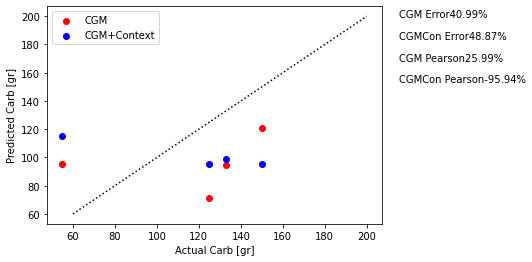

In [113]:
def carbEstXG(trainData,testData,trainLabels,testLabels):
    mseBest=math.inf
    depthBest=float('nan')
    estimatorBest=float('nan')
    modelBest=''

    for numEstimator in np.arange(10,120,10):
        for maxDepth in np.arange(3,10):
            clf = xgb.XGBRegressor(n_estimators =numEstimator,max_depth=maxDepth,objective ='reg:squarederror',eval_metric = "logloss")
            clf.fit(trainData, trainLabels)
            testPrediction = clf.predict(testData)
            mre=[]
            for counter in range(0,len(testPrediction)):
                mre.append(math.fabs(testPrediction[counter]-testLabels[counter])/testLabels[counter])
            mre=np.asarray(mre)
            mre=np.mean(mre)
            if mre<mseBest:
                mreBest=mre
                depthBest=maxDepth
                estimatorBest=numEstimator
                modelBest=clf
                predictionBest=testPrediction
    # print(clf.feature_importances_)
    return modelBest,mreBest,predictionBest,depthBest,estimatorBest

def CGMAucCalculator(timeTemp,dataTemp,mealKernelNum,mealTimes):
    kernelMeans=[]
    kernelSTDs=[]
    for i in range(0,len(mealTimes)-1):
        duration=mealTimes[i+1]-mealTimes[i]
        for j in range(0,mealKernelNum):
            kernelMeans.append(mealTimes[i]+(j+1)*duration/(mealKernelNum+1))
            kernelSTDs.append(duration/(mealKernelNum+1)/2)

    aucData=[]
    for counter in range(0,len(kernelMeans)):
        kernelTemp=np.exp(-((timeTemp-kernelMeans[counter])**2)/(2*kernelSTDs[counter]**2))
        tempAuc=kernelTemp*dataTemp
        tempAuc=np.trapz(tempAuc,x=timeTemp)
        aucData.append(tempAuc/3600)

    return aucData

def contextAucCalculator(timeTemp,dataTemp,kernelNumber):
    kernelMeans=np.linspace(0,24,kernelNumber+2)
    kernelMeans=np.delete(kernelMeans,0)
    kernelMeans=np.delete(kernelMeans,-1)
    kernelMeans=kernelMeans*3600

    kernelSTD=2*3600
    aucData=[]
    for kernelMean in kernelMeans:
        kernelTemp=np.exp(-((timeTemp-kernelMean)**2)/(2*kernelSTD**2))
        tempAuc=kernelTemp*dataTemp
        tempAuc=np.trapz(tempAuc,x=timeTemp)
        aucData.append(tempAuc/3600)

    return aucData

def featureExtractor(df,contextFlag):
    featureList=[]
    sensors=['basis_gsr', 'basis_steps','basis_skin_temperature','basis_heart_rate','glucose_level']
    mealTimes=df[df['Parameter']=='meal']

    mealDes=mealTimes['Extra'].to_list()
    mealTimes=mealTimes['StartTime'].to_list()
    mealDes = [element.lower() for element in mealDes]
    if len(mealTimes)>3:
        del mealTimes[mealDes.index('snack')]
    if len(mealTimes)<3:
        if 'breakfast' not in mealDes:
            print('Breakfast is assumed')
            mealTimes.append(8*3600)
        elif 'lunch' not in mealDes:
            print('Lunch is assumed')
            mealTimes.append(12*3600)
        elif 'dinner' not in mealDes:
            print('Dinner is assumed')
            mealTimes.append(18*3600)
        mealTimes.sort()

    featureLabels=[]
    for sensor in sensors:
        varData=df[df['Parameter']==sensor]
        varTime=varData['StartTime'].tolist()
        varData=varData['Value'].tolist()

        varTime=np.asarray(varTime)
        varData=np.asarray(varData)
        if contextFlag:
            featureList.extend(contextAucCalculator(varTime,varData,9))
            for i in range(0,9):
                featureLabels.append([sensor,'auc'+str(i)])
            featureList.extend(contextAucCalculator(varTime,varData,6))
            for i in range(0,6):
                featureLabels.append([sensor,'auc'+str(i)])

        if sensor=='glucose_level':
            featureList.extend(CGMAucCalculator(varTime,varData,3,mealTimes))
            for i in range(0,9):
                featureLabels.append([sensor,'auc'+str(i)])
            featureList.extend(CGMAucCalculator(varTime,varData,2,mealTimes))
            for i in range(0,6):
                featureLabels.append([sensor,'auc'+str(i)])
            featureList.extend(CGMAucCalculator(varTime,varData,1,mealTimes))
            for i in range(0,3):
                featureLabels.append([sensor,'auc'+str(i)])
    # print("Used features",featureLabels)
    #https://github.com/fraunhoferportugal/tsfel/tree/9319db4368303cf10adb3aeb72cd4235a8085307

    return featureList

def testTrainSplitFuncAux(dfSensorTemp,dfMacroTemp,contextFlag):
    sensorDataList=[]
    macroDataList=[]
    days=list(set(dfSensorTemp['StartDay']))

    for day in days:
        dfSensorTempDay=dfSensorTemp[dfSensorTemp['StartDay']==day]
        sensorDataList.append(featureExtractor(dfSensorTempDay,contextFlag))
        dfMacroTempDay=dfMacroTemp[dfMacroTemp['StartDay']==day]
        totalCarb=dfMacroTempDay['Value'].to_list()
        totalCarb=float(totalCarb[0])
        totalFat=float('nan')
        totalProtein=float('nan')
        macroDataList.append([totalCarb,totalFat,totalProtein])

    return sensorDataList,macroDataList

def featureNormalizer(trainData,testData):
    scaler = StandardScaler()
    trainData = scaler.fit_transform(trainData)
    testData = scaler.fit_transform(testData)

    return trainData,testData

def testTrainSplitFunc(dfSensor, dfMacro,randomSeed,contextFlag):
    days=list(set(dfSensor['StartDay']))
    random.seed(randomSeed)
    random.shuffle(days)
    daysTrain=days[0:6]
    daysTest=days[6:10]

    dfSensorTrain = dfSensor[dfSensor['StartDay'].isin(daysTrain)]
    dfSensorTest = dfSensor[dfSensor['StartDay'].isin(daysTest)]

    dfMacroTrain= dfMacro[dfMacro['StartDay'].isin(daysTrain)]
    dfMacroTest= dfMacro[dfMacro['StartDay'].isin(daysTest)]

    trainData,trainLabel=testTrainSplitFuncAux(dfSensorTrain,dfMacroTrain,contextFlag)
    testData,testLabel=testTrainSplitFuncAux(dfSensorTest,dfMacroTest,contextFlag)

    trainData=np.asarray(trainData)
    testData=np.asarray(testData)

    trainLabel=np.asarray(trainLabel)
    testLabel=np.asarray(testLabel)

    trainLabel=trainLabel[:,0]
    testLabel=testLabel[:,0]
    trainData,testData=featureNormalizer(trainData,testData)

    return trainData,testData,trainLabel,testLabel,daysTest,daysTrain

for counter in range(0,1):
    randomSeed=random.randrange(100)
    selectedSensors=['basis_gsr','basis_steps','basis_skin_temperature','basis_heart_rate','glucose_level','meal']
    filterIndex=df.Parameter.isin(selectedSensors)
    dfSensor = df[filterIndex]
    dfMacro=df[df['Parameter']=='CarbSum']

    trainData,testData,trainLabel,testLabel,daysTest,daysTrain=testTrainSplitFunc(dfSensor,dfMacro,randomSeed=randomSeed,contextFlag=True)
    _,mreBestCGMContext,predictionBestCGMContext,_,_=carbEstXG(trainData,testData,trainLabel,testLabel)
    pearsonCGMContext=pearsonr(predictionBestCGMContext,testLabel)
    pearsonCGMContext=pearsonCGMContext[0]

    trainData,testData,trainLabel,testLabel,daysTest,daysTrain=testTrainSplitFunc(dfSensor,dfMacro,randomSeed=randomSeed,contextFlag=False)
    _,mreBestCGM,predictionBestCGM,_,_=carbEstXG(trainData,testData,trainLabel,testLabel)
    pearsonCGM=pearsonr(predictionBestCGM,testLabel)
    pearsonCGM=pearsonCGM[0]


plt.figure()
plt.scatter(x=testLabel,y=predictionBestCGM,color='red',label='CGM')
plt.scatter(x=testLabel,y=predictionBestCGMContext,color='blue',label='CGM+Context')
plt.plot([60,200],[60,200],':k')
# plt.scatter(x=daysTest,y=predictionBestCGMContext,label='Prediction CGM+Con')
# plt.scatter(x=daysTest,y=predictionBestCGM,label='Prediction CGM')
plt.annotate('CGM Error'+str(round(100*mreBestCGM,2))+'%', xy=(1.05, 0.95), xycoords='axes fraction')
plt.annotate('CGMCon Error'+str(round(100*mreBestCGMContext,2))+'%', xy=(1.05, 0.85), xycoords='axes fraction')

plt.annotate('CGM Pearson'+str(round(100*pearsonCGM,2))+'%', xy=(1.05, 0.75), xycoords='axes fraction')
plt.annotate('CGMCon Pearson'+str(round(100*pearsonCGMContext,2))+'%', xy=(1.05, 0.65), xycoords='axes fraction')

plt.xlabel('Actual Carb [gr]')
plt.ylabel('Predicted Carb [gr]')
plt.legend(loc='upper left')
plt.savefig('C:\GitHub\Carb.png')